In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


**Dataset is about whether the user subscribes to the term deposit or not**

# EDA Analysis

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
data = "/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv"
test = "/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv"
df = pd.read_csv(data) 
print(df.info)
print(df.shape)

<bound method DataFrame.info of       last contact date  age           job   marital  education default  \
0            2009-04-17   26   blue-collar   married  secondary      no   
1            2009-10-11   52    technician   married  secondary      no   
2            2010-11-20   44   blue-collar   married  secondary      no   
3            2009-09-01   33        admin.   married  secondary      no   
4            2008-01-29   31  entrepreneur    single   tertiary      no   
...                 ...  ...           ...       ...        ...     ...   
39206        2008-07-31   31    technician    single  secondary      no   
39207        2009-07-31   59        admin.   married    primary      no   
39208        2008-06-02   36   blue-collar   married  secondary      no   
39209        2010-03-20   28       student    single  secondary      no   
39210        2010-03-16   51       student  divorced   tertiary     yes   

       balance housing loan    contact  duration  campaign  pdays  

In [3]:
df.dtypes
#6 numerical
# 10 categorical includding the target

last contact date    object
age                   int64
job                  object
marital              object
education            object
default              object
balance               int64
housing              object
loan                 object
contact              object
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome             object
target               object
dtype: object

In [4]:
df.describe(include=[np.number])

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
df.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [6]:
# value counts for each categorical column

categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
for i in categorical_cols:
    print(f"->Column name = {df[i].value_counts()}")
    print("")

->Column name = job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64

->Column name = marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64

->Column name = education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64

->Column name = default
no     36954
yes     2257
Name: count, dtype: int64

->Column name = housing
yes    21657
no     17554
Name: count, dtype: int64

->Column name = loan
no     31820
yes     7391
Name: count, dtype: int64

->Column name = contact
cellular     25030
telephone     3845
Name: count, dtype: int64

->Column name = poutcome
failure    4949
other      2560
success    2251
Name: count, dtype: int64



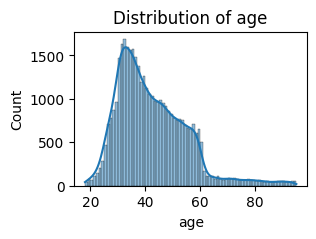

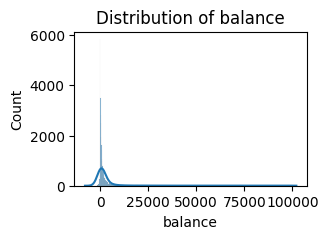

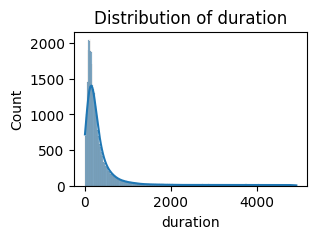

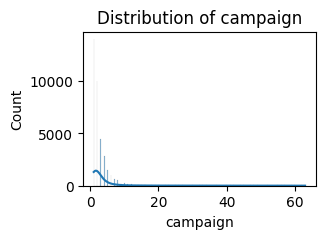

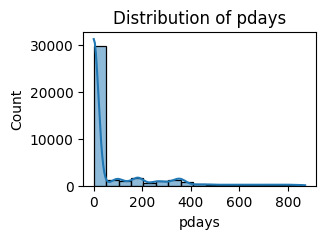

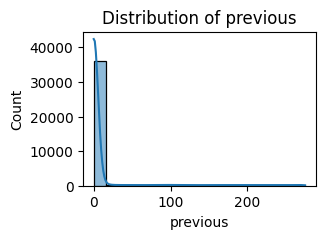

In [7]:
# to get information about the distribution and the skewness
# used kde (kernel density estimation) which gives the density of each variable's probability value
import seaborn as sns
import matplotlib.pyplot as plt
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
for col in numeric_cols:
    plt.figure(figsize=(3,2))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

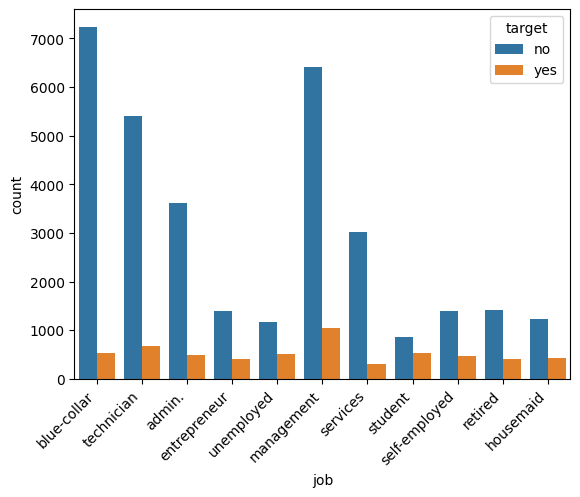

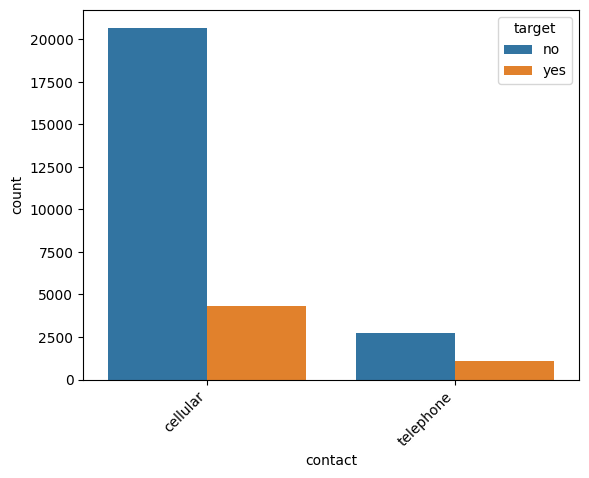

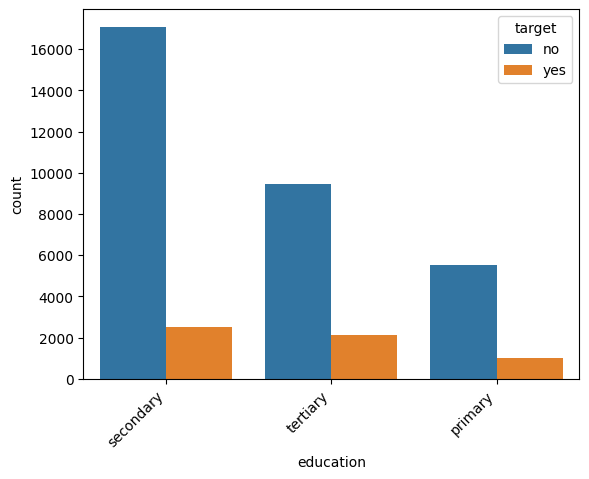

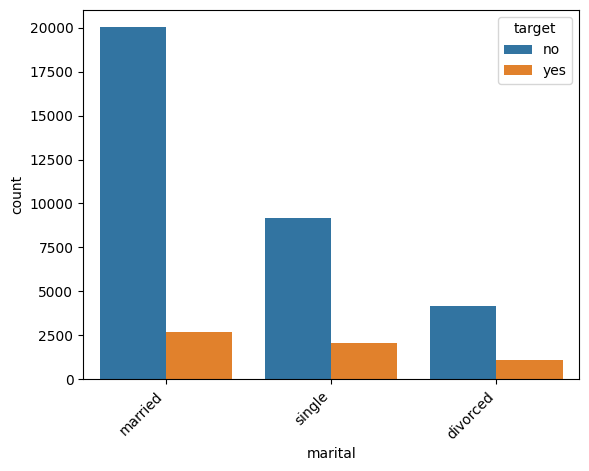

In [8]:
# joint count distribution with target variable

sns.countplot(x='job', hue='target', data=df)
plt.xticks(rotation=45, ha='right')
plt.show()

sns.countplot(x='contact', hue='target', data=df)
plt.xticks(rotation=45, ha='right')
plt.show()

sns.countplot(x='education', hue='target', data=df)
plt.xticks(rotation=45, ha='right')
plt.show()

sns.countplot(x='marital', hue='target', data=df)
plt.xticks(rotation=45, ha='right')
plt.show()

<Axes: >

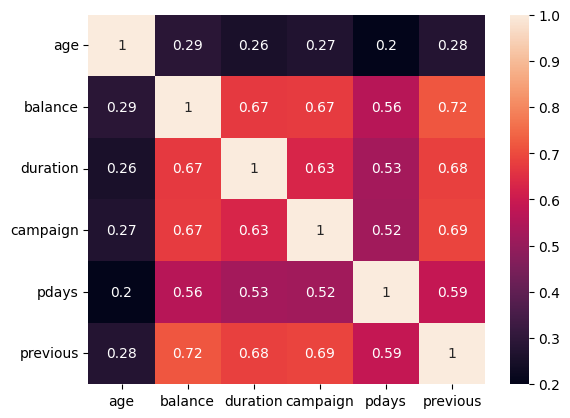

In [9]:
# correlation matrix for num type columns to check how related the numeric columns are to each other

corr_matrix = df[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].corr()
sns.heatmap(corr_matrix, annot=True)

In [10]:
# sample submission format checking

ss= pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
ss.head(3)

,id,target
0,0,no
1,1,no
2,2,no


# Data Preprocessing and Feature Engineering

- Based on the above EDA, the main points for our preprocessing came out to be
    - Engineering 'last contact date' column
    - Handling missing values
    - Encoding Columns as necessary

**Engineering 'last contact date' column**

In [11]:
# 'last contact date' column engineering

''' date columns starts from 2008-01-01 till 2010-12-30 
the below commented code converts the date column to the number of date from the minimum days
not a good approach '''
# df = pd.read_csv(data)
# df['last contact date'] = pd.to_datetime(df['last contact date'], errors='coerce')
# df['last contact date'] = (df['last contact date'] - df['last contact date'].min()) / pd.Timedelta(days=1)


'''this below is another method and simply adds columns '''
df = pd.read_csv(data)
df['last_contact_date'] = pd.to_datetime(df['last contact date'])
df['year'] = df['last_contact_date'].dt.year
df['month'] = df['last_contact_date'].dt.month
df['day'] = df['last_contact_date'].dt.day
df['day_of_week'] = df['last_contact_date'].dt.weekday
df['quarter'] = df['last_contact_date'].dt.quarter
df['is_weekend'] = (df['last_contact_date'].dt.weekday >= 5).astype(int)  # 1 if weekend else 0
df.drop(columns=['last contact date'], inplace=True)

''' this below coverts the last contact date to two different columns
'last contact year' and 'last contact month' removing the date column. more preferabble'''
# df = pd.read_csv(data)
# df['last_contact_year'] = pd.to_datetime(df['last contact date'], errors='coerce').dt.year
# df['last_contact_month'] = pd.to_datetime(df['last contact date'], errors='coerce').dt.month
# df.drop(columns=['last contact date'], inplace=True)


df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,last_contact_date,year,month,day,day_of_week,quarter,is_weekend
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no,2009-04-17,2009,4,17,4,2,0
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no,2009-10-11,2009,10,11,6,4,1
2,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no,2010-11-20,2010,11,20,5,4,1
3,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no,2009-09-01,2009,9,1,1,3,0
4,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no,2008-01-29,2008,1,29,1,1,0


**Handling missing values**

In [12]:
''' Total 4 columns has missing values 'jobs' 'education' 'contact' 'poutcome'
        
        For both 'jobs' 'education' columns, filling the value with most_frequent or 'unknown' seems 
        viable, so I will make two versions of this dataset.
        
        For 'contact' and 'poutcome, I prefer filling 'contact' with most_frequent and 'poutcome' 
        with 'unknown'
    '''
#mode imputation
df_mode = df.copy()
df_mode['job'].fillna(df_mode['job'].mode()[0], inplace=True)
df_mode['education'].fillna(df_mode['education'].mode()[0], inplace=True)
df_mode['poutcome'].fillna('unknown', inplace=True)
df_mode['contact'].fillna(df_mode['contact'].mode()[0], inplace=True)
# print(df_mode.isnull().sum())

# unknown category
df_unknown = df.copy()
df_unknown['job'].fillna('unknown', inplace=True)
df_unknown['education'].fillna('unknown', inplace=True)
df_unknown['poutcome'].fillna('unknown', inplace=True)
df_unknown['contact'].fillna(df_unknown['contact'].mode()[0], inplace=True)
df_unknown.isnull().sum()

# knnn imputTION

age                  0
job                  0
marital              0
education            0
default              0
balance              0
housing              0
loan                 0
contact              0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
target               0
last_contact_date    0
year                 0
month                0
day                  0
day_of_week          0
quarter              0
is_weekend           0
dtype: int64

**Encoding Columns as Necessary**
-    used power transformer for outliers as all the numerical features are right-skewed as it handles both +ve and -ve values
-    Log transformer example:    df_log_transformed[feature] = np.log(df[feature])

**df_mode pipeline**

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df_mode = df.copy()

numeric_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),  
    ('scaler', StandardScaler())  
])
# knn imputation
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features), 
        ('cat', categorical_pipeline, categorical_columns)  
    ]
)
df_processed = preprocessor.fit_transform(df_mode)
encoded_column_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)

df_encoded_mode = pd.DataFrame(df_processed, columns=numeric_features + list(encoded_column_names))
df_final_mode = df_encoded_mode
# print(df_final_mode.head())
isinstance(df_final_mode, pd.DataFrame)


True

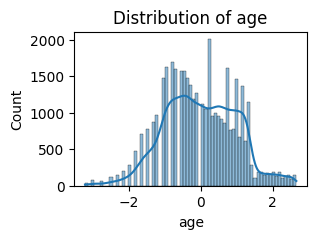

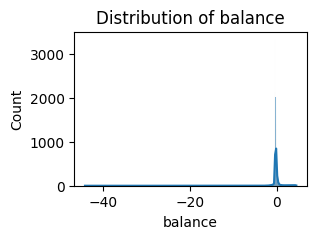

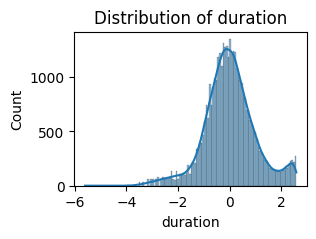

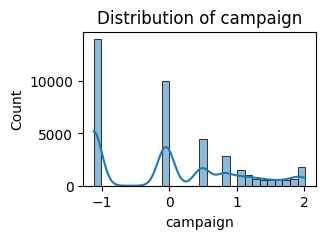

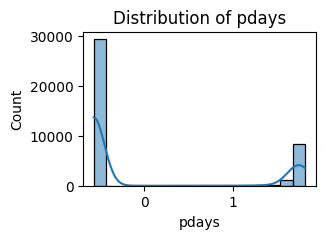

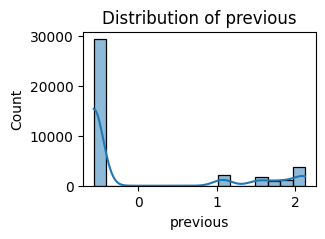

In [14]:
for i in numeric_features:
    plt.figure(figsize=(3,2))
    sns.histplot(df_final_mode[i], kde=True)
    plt.title(f'Distribution of {i}')
    plt.show()

**df_unknown pipeline**

In [15]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

numeric_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

df_unknown = df_unknown.copy()

df_unknown[numeric_features] = df_unknown[numeric_features].fillna(df_unknown[numeric_features].median())

scaler_power = PowerTransformer(method='yeo-johnson', standardize=False)
df_unknown[numeric_features] = scaler_power.fit_transform(df_unknown[numeric_features])

scaler_standard = StandardScaler()
df_unknown[numeric_features] = scaler_standard.fit_transform(df_unknown[numeric_features])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns)
    ]
)
df_encoded_unknown = preprocessor.fit_transform(df_unknown)

df_encoded_unknown = pd.DataFrame(df_encoded_unknown.toarray(), columns=preprocessor.get_feature_names_out())
non_categorical_columns_unknown = df_unknown.drop(columns=categorical_columns).reset_index(drop=True)

df_final_unknown = pd.concat([non_categorical_columns_unknown, df_encoded_unknown], axis=1)

isinstance(df_final_unknown, pd.DataFrame)

True

In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

train_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
sample_submission = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")

def preprocess_data(df):
    df['last contact date'] = pd.to_datetime(df['last contact date'])
    df['contact_year'] = df['last contact date'].dt.year
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_day'] = df['last contact date'].dt.day
    df['contact_dayofweek'] = df['last contact date'].dt.dayofweek
    df.drop('last contact date', axis=1, inplace=True)
    
    for col in ['job', 'education', 'contact', 'poutcome']:
        df[col] = df[col].fillna('Unknown')
    
    df_encoded = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])
    return df_encoded

train_df_encoded = preprocess_data(train_df)
test_df_encoded = preprocess_data(test_df)

test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)

X = train_df_encoded.drop('target', axis=1)
y = train_df_encoded['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_test_final = test_df_encoded.drop('target', axis=1)

pipeline_rf = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTEENN(random_state=42)),
    ('model', RandomForestClassifier(max_depth=12, n_estimators=120, min_samples_split=5,
                                     min_samples_leaf=2, random_state=42, n_jobs=-1))
])

pipeline_xgb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTEENN(random_state=42)),
    ('model', XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=100,
                            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
                            use_label_encoder=False, eval_metric='logloss'))
])

pipeline_lgbm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTEENN(random_state=42)),
    ('model', LGBMClassifier(max_depth=10, learning_rate=0.1, n_estimators=100,
                             subsample=0.8, random_state=42, n_jobs=-1))
])

voting_clf = VotingClassifier(estimators=[
    ('rf', pipeline_rf),
    ('xgb', pipeline_xgb),
    ('lgbm', pipeline_lgbm)
], voting='soft', n_jobs=-1)

voting_clf.fit(X, y)
print("Model trained.")

test_probs = voting_clf.predict_proba(X_test_final)[:, 1]

# thresholds = np.arange(0.50, 0.58, 0.001)
# for thresh in thresholds:
#     test_predictions = (test_probs >= thresh).astype(int)
#     test_predictions_labels = ['yes' if pred == 1 else 'no' for pred in test_predictions]
#     yes_count = test_predictions_labels.count('yes')
#     print(f"Threshold: {thresh:.2f} | 'yes' count: {yes_count}")

# max f1 score threshold
adjusted_threshold = 0.53
test_predictions_final = (test_probs >= adjusted_threshold).astype(int)
test_predictions_labels_final = ['yes' if pred == 1 else 'no' for pred in test_predictions_final]

print("Final test set predictions value counts:")
print(pd.Series(test_predictions_labels_final).value_counts())

sample_submission['target'] = test_predictions_labels_final
sample_submission.to_csv('submission.csv', index=False)
print("Submission file created.")
submission_df = pd.read_csv('submission.csv')
print(submission_df['target'].value_counts())


Model trained.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Final test set predictions value counts:
no     7784
yes    2216
Name: count, dtype: int64
Submission file created.
target
no     7784
yes    2216
Name: count, dtype: int64


In [35]:
submission_df = pd.read_csv('submission.csv')
print(submission_df['target'].value_counts())

target
no     7784
yes    2216
Name: count, dtype: int64
